In [1]:
import pandas as pd
import numpy as np
import warnings
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
from expected_score_model.evaluation.model_evaluator import ModelEvaluator
from expected_score_model.evaluation.classification_evaluator import ClassificationModelEvaluator
from expected_score_model.evaluation.regression_evaluator import RegressionModelEvaluator
from expected_score_model.evaluation.catboost_evaluator import CatBoostEvaluator

In [3]:
from expected_score_model.preprocessing.preprocessor import ExpectedScorePreprocessor
from expected_score_model.preprocessing.response import create_expected_score_response

In [4]:
chains = pd.read_csv('/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/AFL_Chains.csv')

In [5]:
chains = create_expected_score_response(chains)

In [6]:
chains.head()

CD_Player_ID  Chain_Number Team_Chain Initial_State Final_State  \
0          NaN             1   Brisbane  centreBounce    turnover   
1   CD_I293535             1   Brisbane  centreBounce    turnover   
2   CD_I293535             1   Brisbane  centreBounce    turnover   
3  CD_I1002401             1   Brisbane  centreBounce    turnover   
4  CD_I1002401             1   Brisbane  centreBounce    turnover   

   Period_Number  Period_Duration_Chain_Start        Description   Disposal  \
0            1.0                          0.0      Centre Bounce        NaN   
1            1.0                          0.0      Hard Ball Get        NaN   
2            1.0                          0.0           Handball  effective   
3            1.0                          0.0  Handball Received        NaN   
4            1.0                          0.0           Handball  effective   

  Shot_At_Goal Behind_Detail  Order  Period_Duration     x     y Home_Team  \
0          NaN           NaN    1.0              0.0   0.0   0.0    Sydney   
1          NaN           NaN    2.0              8.0 -12.0 -11.0    Sydney   
2          NaN           NaN    3.0              8.0 -13.0 -11.0    Sydney   
3          NaN           NaN    4.0             10.0 -19.0 -13.0    Sydney   
4          NaN           NaN    5.0             10.0 -19.0 -11.0    Sydney   

  Away_Team Home_Team_Direction_Q1  Venue_Width  Venue_Length  \
0  Brisbane                  right        141.0         160.0   
1  Brisbane                  right        141.0         160.0   
2  Brisbane                  right        141.0         160.0   
3  Brisbane                  right        141.0         160.0   
4  Brisbane                  right        141.0         160.0   

               Player      Team                     Match_ID  \
0                 NaN       NaN  AFL_2024_F4_Sydney_Brisbane   
1        Lachie Neale  Brisbane  AFL_2024_F4_Sydney_Brisbane   
2        Lachie Neale  Brisbane  AFL_2024_F4_Sydney_Brisbane   
3  Brandon Starcevich  Brisbane  AFL_2024_F4_Sydney_Brisbane   
4  Brandon Starcevich  Brisbane  AFL_2024_F4_Sydney_Brisbane   

            Player_ID result  score  miss  behind  goal  
0                 NaN   miss      0     1       0     0  
1        lachie_neale   miss      0     1       0     0  
2        lachie_neale   miss      0     1       0     0  
3  brandon_starcevich   miss      0     1       0     0  
4  brandon_starcevich   miss      0     1       0     0

In [7]:
xs_preproc = ExpectedScorePreprocessor()
X_shots, y_shots = xs_preproc.fit_transform(chains, chains['result'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_shots, y_shots, test_size=0.2, random_state=42)

In [9]:
cat_features = list(X_train.select_dtypes(include='object').columns)

In [10]:
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss

# Create and fit the model
model = CatBoostClassifier(
        iterations=1000,
        cat_features=cat_features, 
        loss_function='MultiClass', 
        eval_metric='MultiClass',
        verbose=100)
model.fit(X_train, y_train)

# Predict probabilities for each class
y_test_pred_proba = model.predict_proba(X_test)

# Calculate log loss
logloss = log_loss(y_test, y_test_pred_proba)
print(f'Log Loss: {logloss}')

Learning rate set to 0.094645
0:	learn: 1.0703978	total: 96.2ms	remaining: 1m 36s
100:	learn: 0.8851300	total: 2.44s	remaining: 21.7s
200:	learn: 0.8661467	total: 4.84s	remaining: 19.2s
300:	learn: 0.8504890	total: 7.75s	remaining: 18s
400:	learn: 0.8348383	total: 10.3s	remaining: 15.4s
500:	learn: 0.8205745	total: 12.7s	remaining: 12.6s
600:	learn: 0.8067661	total: 15.4s	remaining: 10.2s
700:	learn: 0.7936506	total: 17.7s	remaining: 7.54s
800:	learn: 0.7812688	total: 20.3s	remaining: 5.04s
900:	learn: 0.7689993	total: 22.5s	remaining: 2.47s
999:	learn: 0.7570655	total: 24.7s	remaining: 0us
Log Loss: 0.9026929571895572


In [11]:
class_names = model.classes_
predicted_probabilities = model.predict_proba(X_test)

class_probabilities = {f'predicted_proba_{class_names[i]}': predicted_probabilities[:, i] for i in range(len(class_names))}

In [12]:
predicted_score = class_probabilities['predicted_proba_goal']*6 + class_probabilities['predicted_proba_behind']*1
predicted_result = model.predict(X_test).flatten()

In [34]:
actual_score = chains.loc[y_test.index, 'score']
goal = chains.loc[y_test.index, 'goal']
behind = chains.loc[y_test.index, 'behind']
miss = chains.loc[y_test.index, 'miss']

actuals_binary = np.array(chains.loc[y_test.index, model.classes_])

Model Evaluation

In [15]:
model_eval = ModelEvaluator(model = model)

In [16]:
model_eval.averages(actual = score, predicted = predicted_score)

{'actual': 3.333373134328358, 'predicted': 3.3377172736643503}

In [18]:
model_eval.averages(actual = goal, predicted = class_probabilities['predicted_proba_goal'])

{'actual': 0.4982686567164179, 'predicted': 0.49950539031880264}

In [20]:
model_eval.averages(actual = behind, predicted = class_probabilities['predicted_proba_behind'])

{'actual': 0.3437611940298507, 'predicted': 0.3406849317515342}

In [19]:
model_eval.averages(actual = miss, predicted = class_probabilities['predicted_proba_miss'])

{'actual': 0.15797014925373135, 'predicted': 0.1598096779296631}

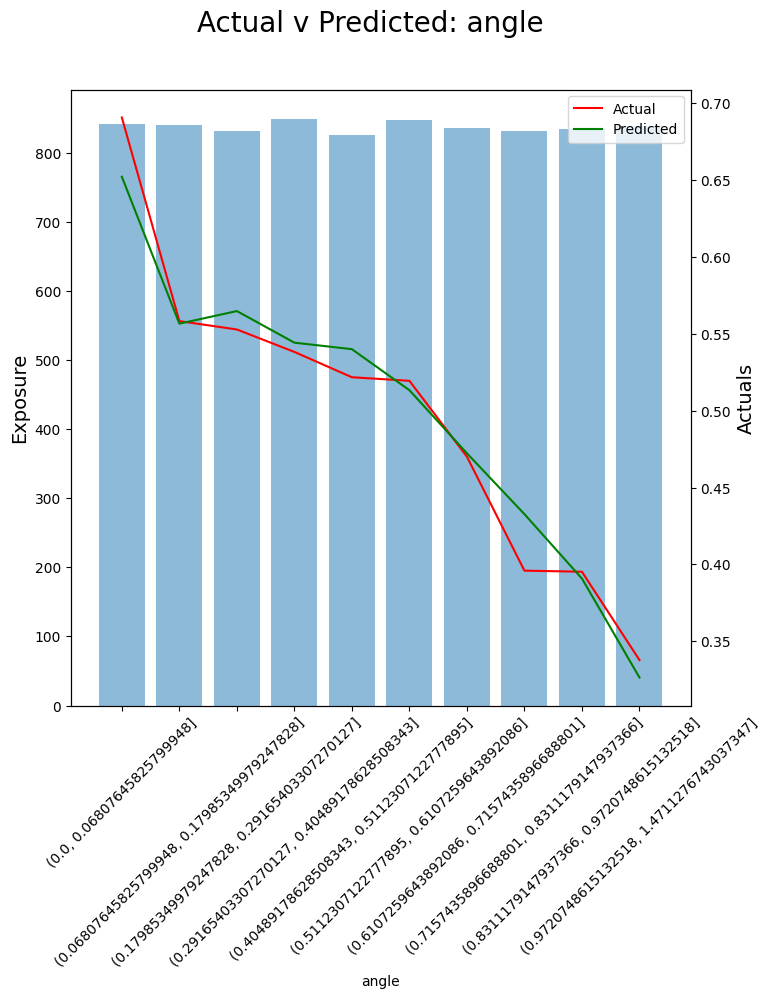

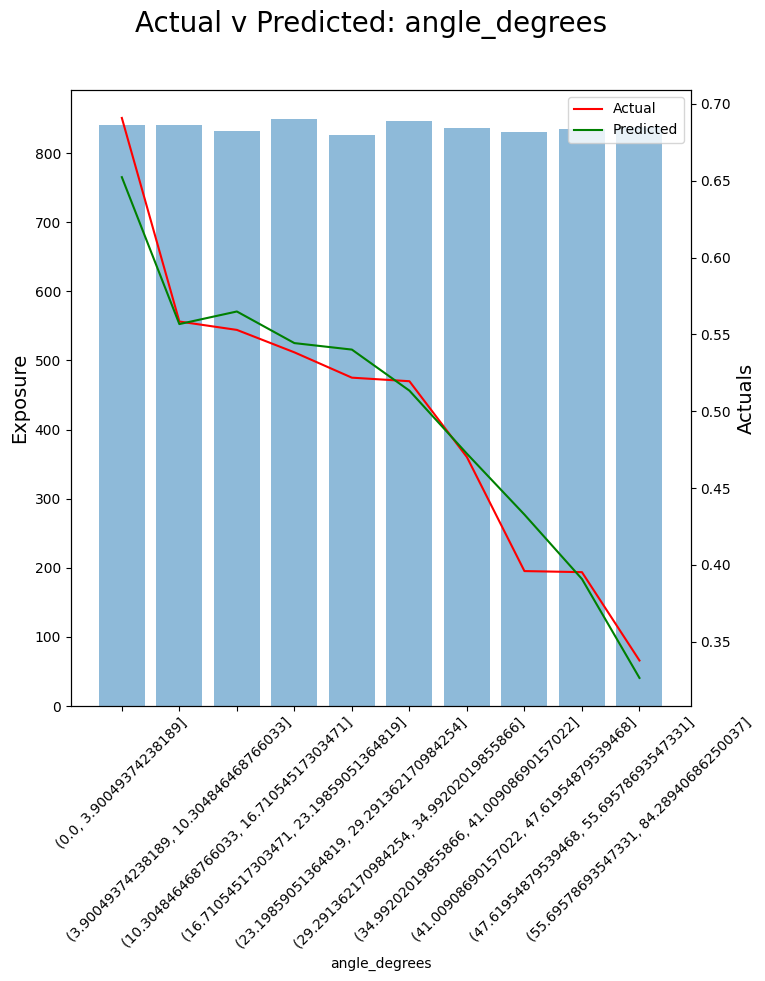

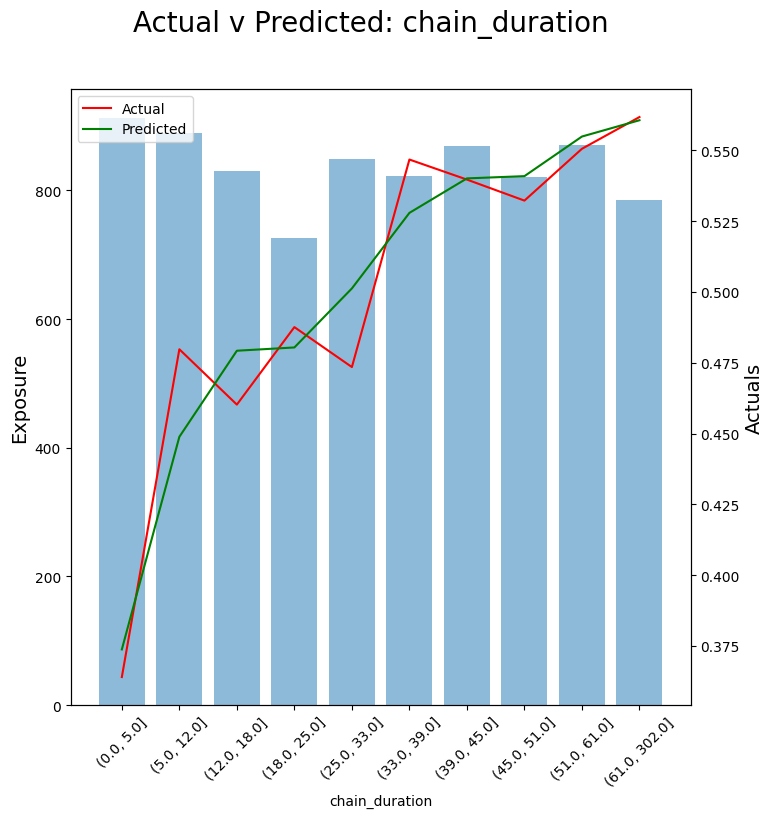

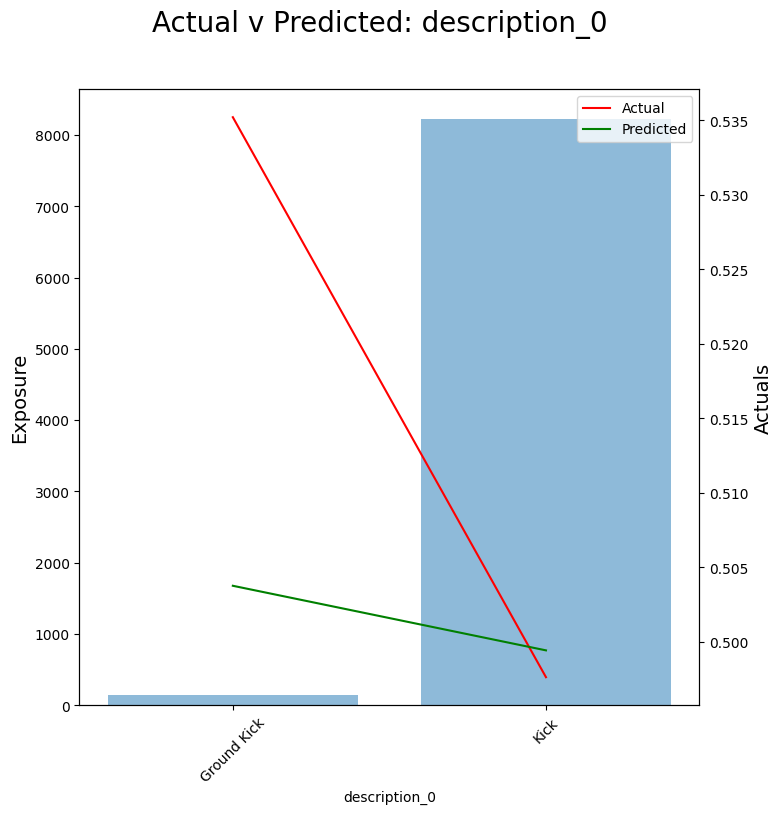

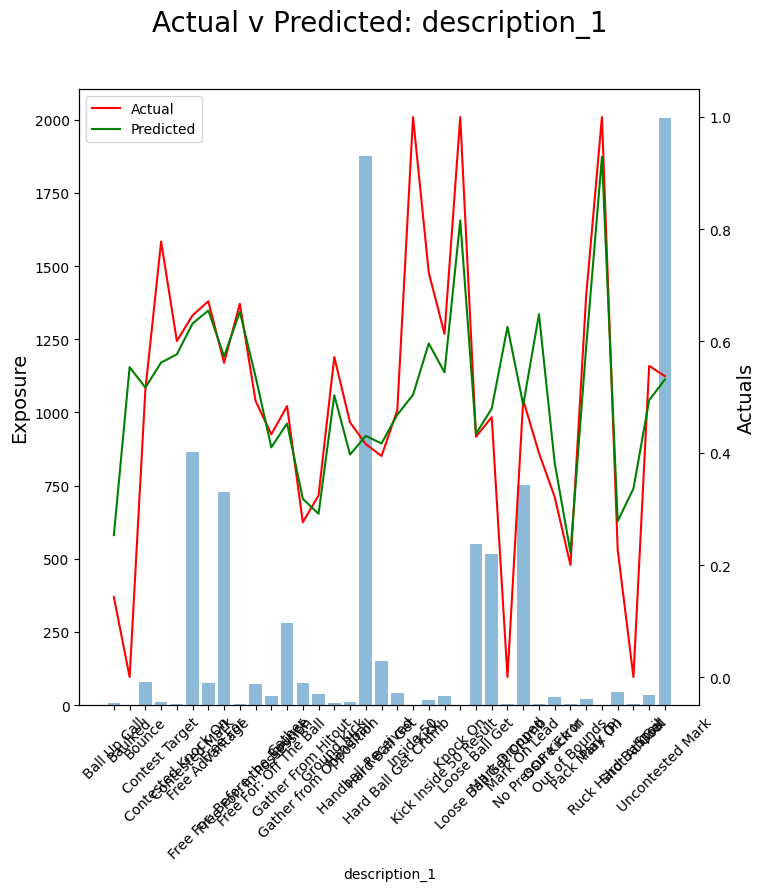

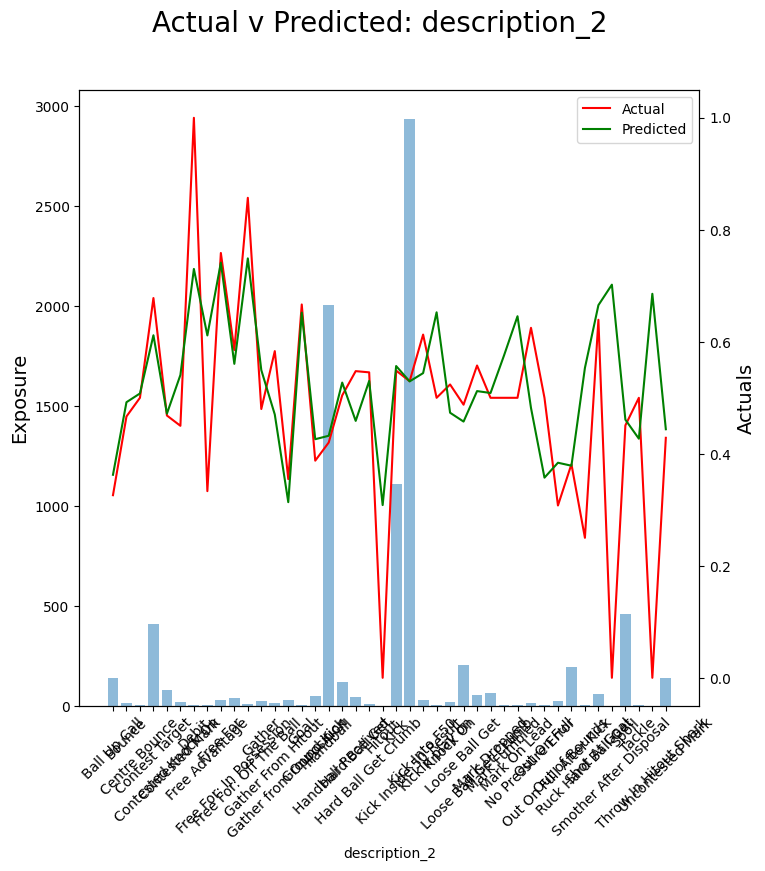

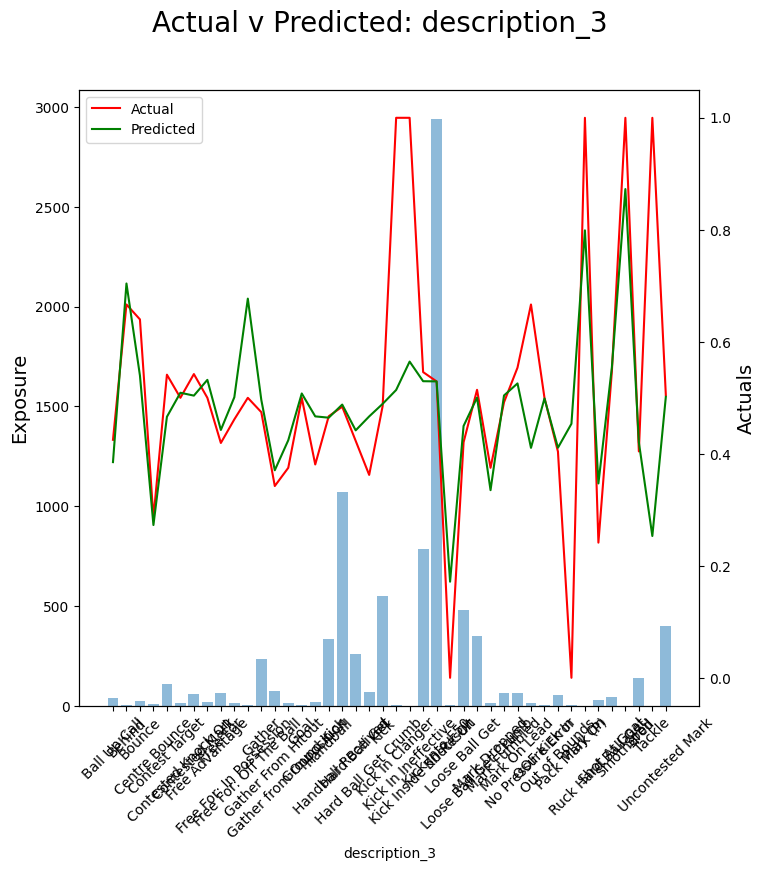

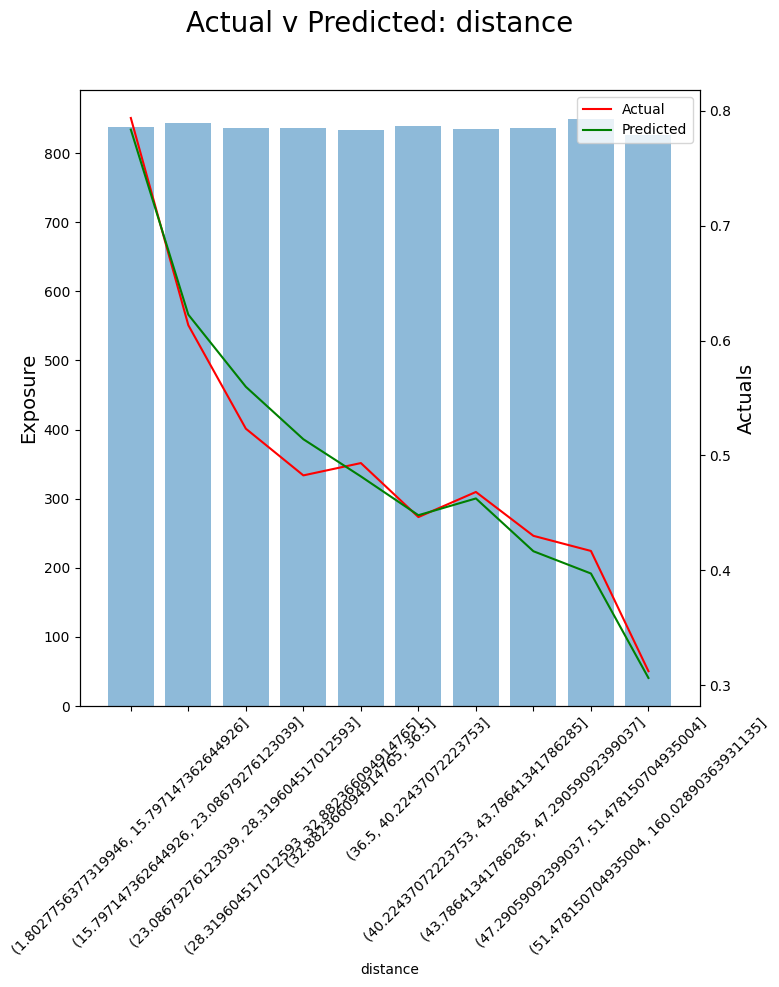

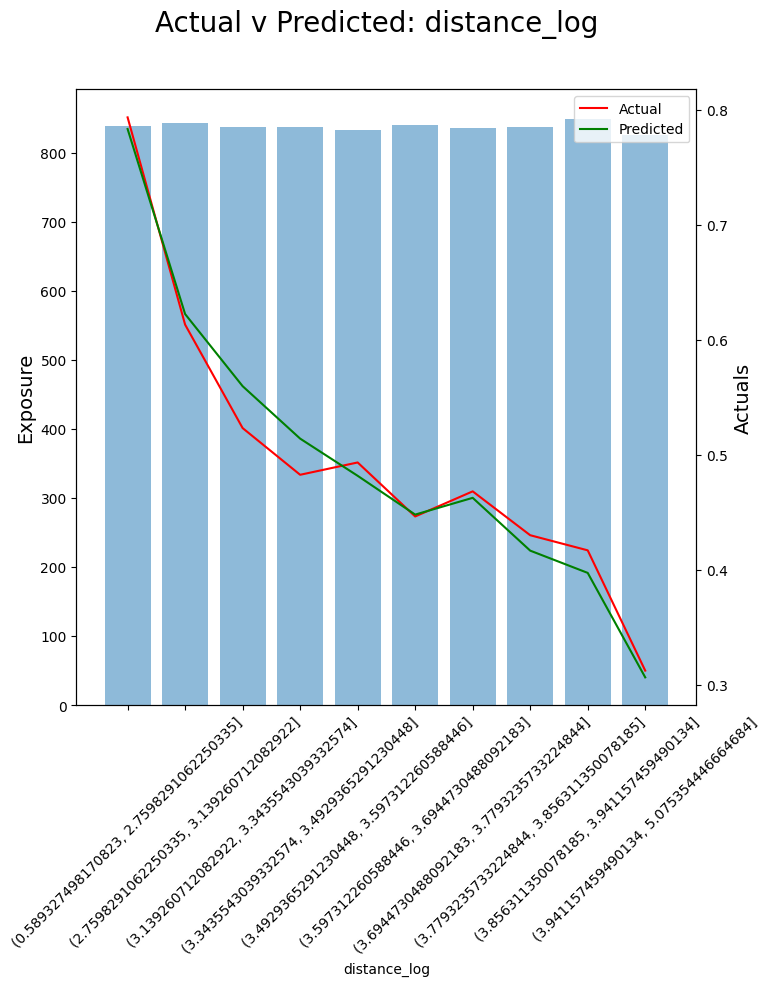

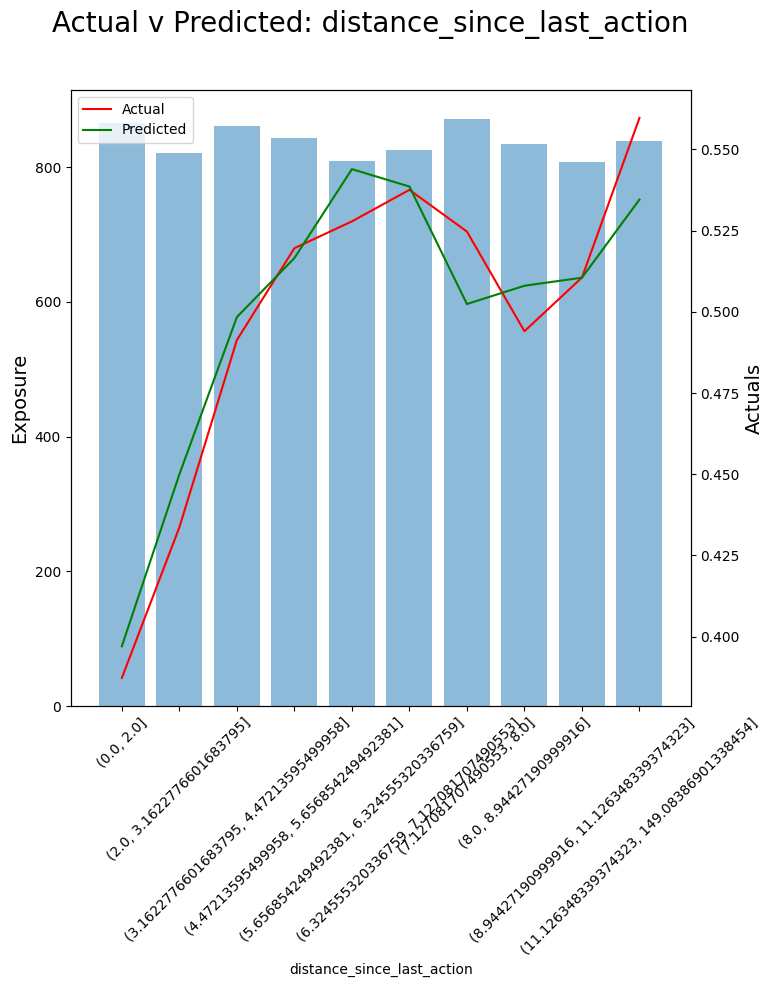

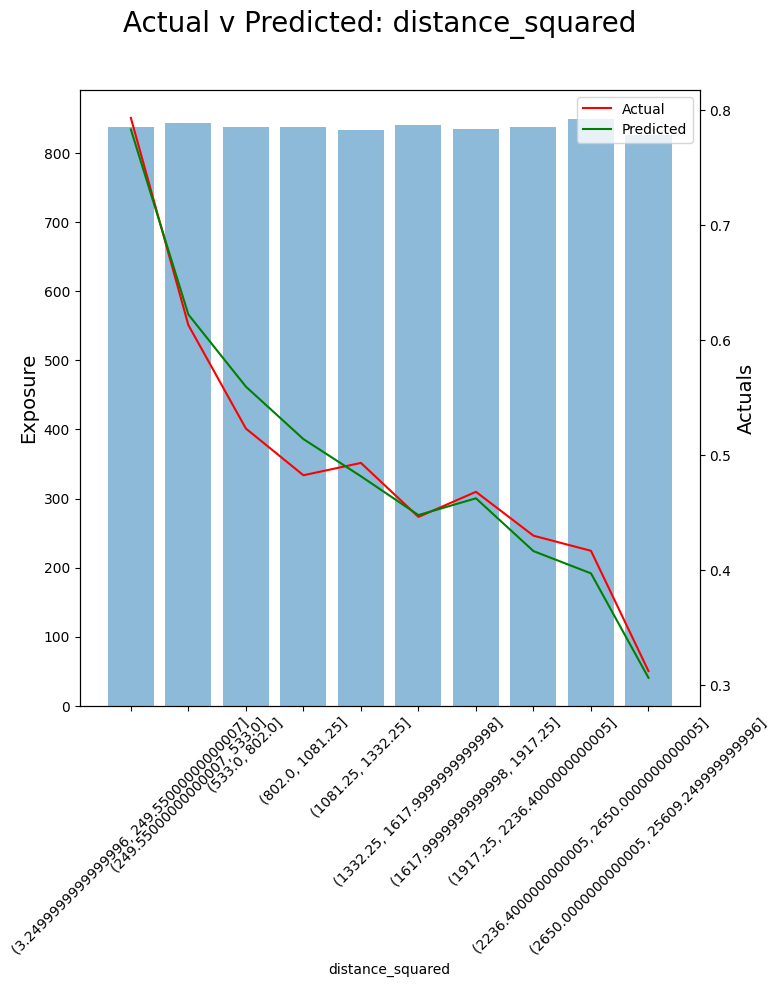

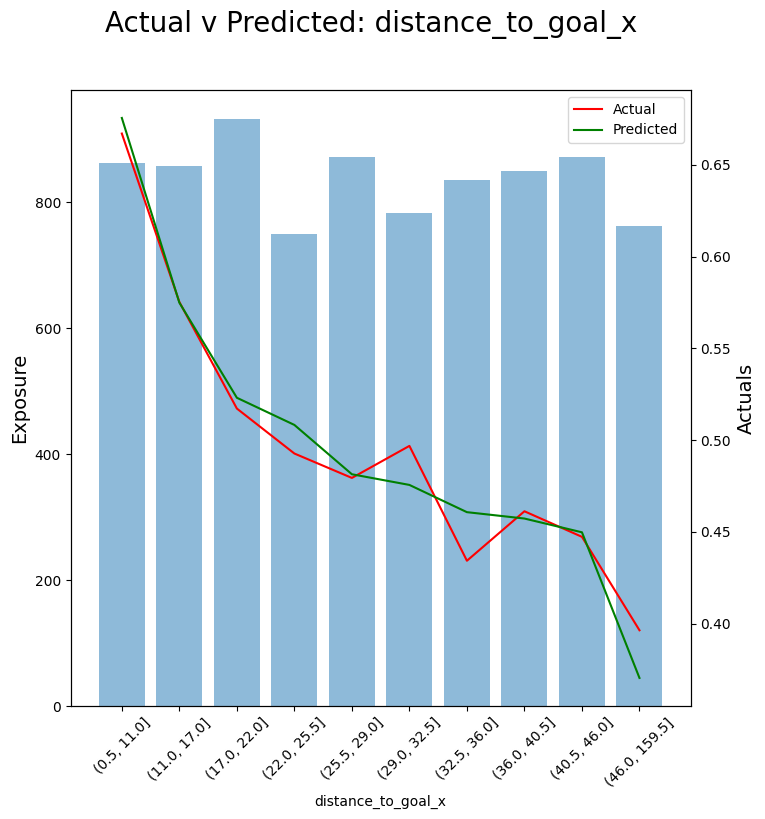

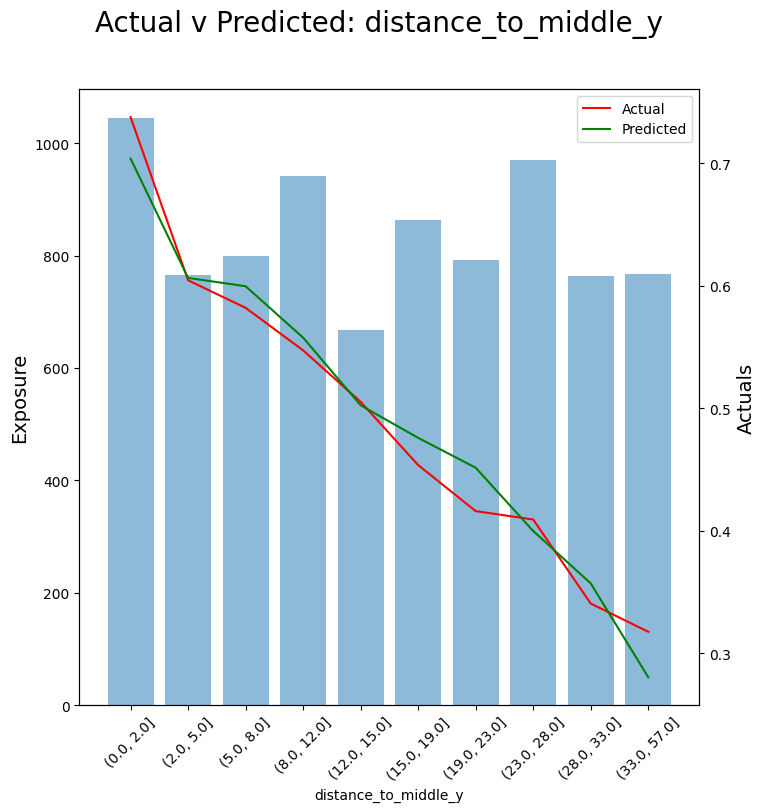

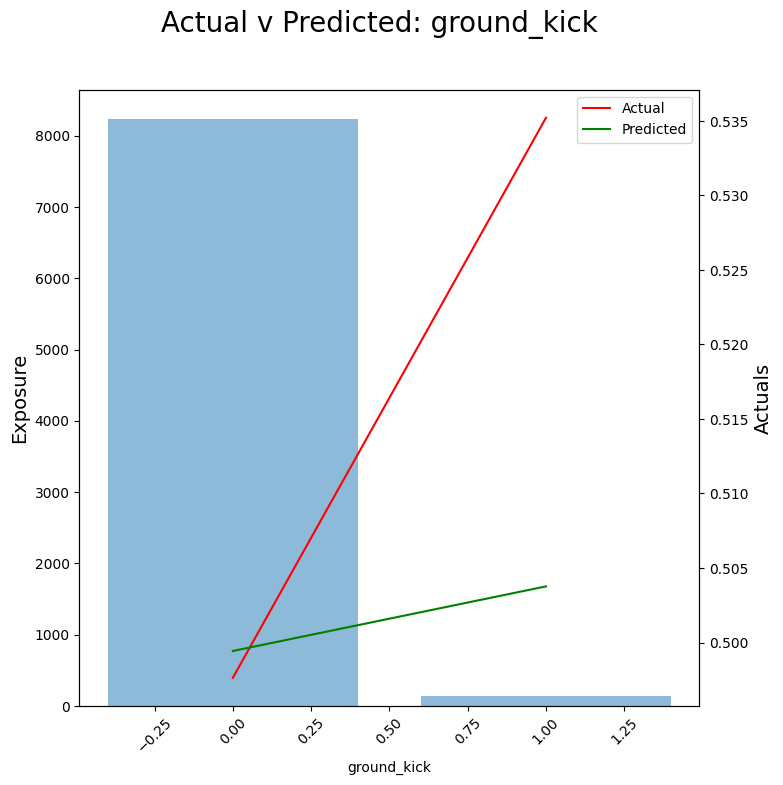

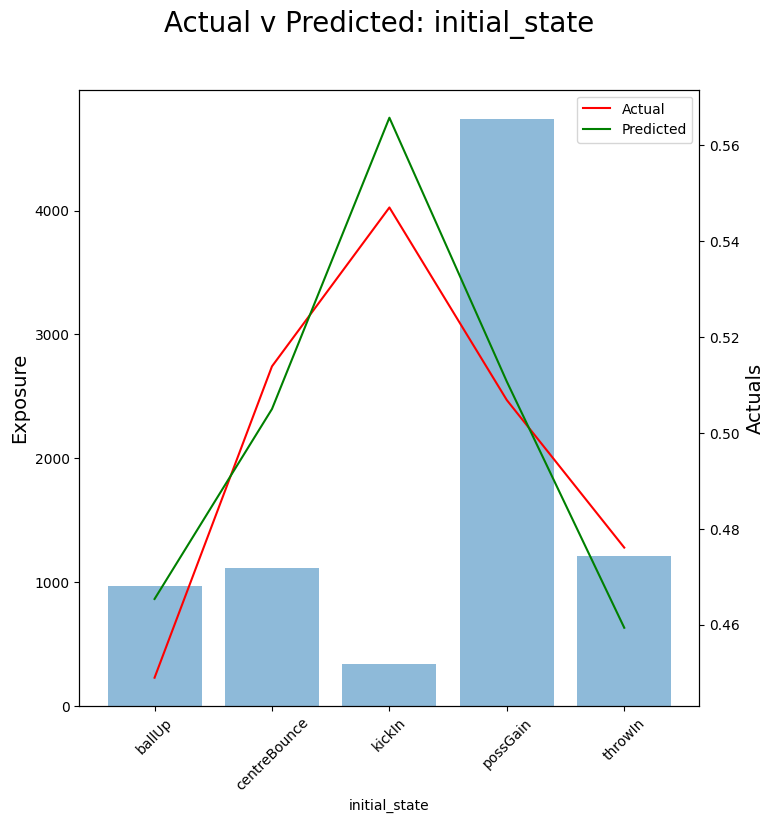

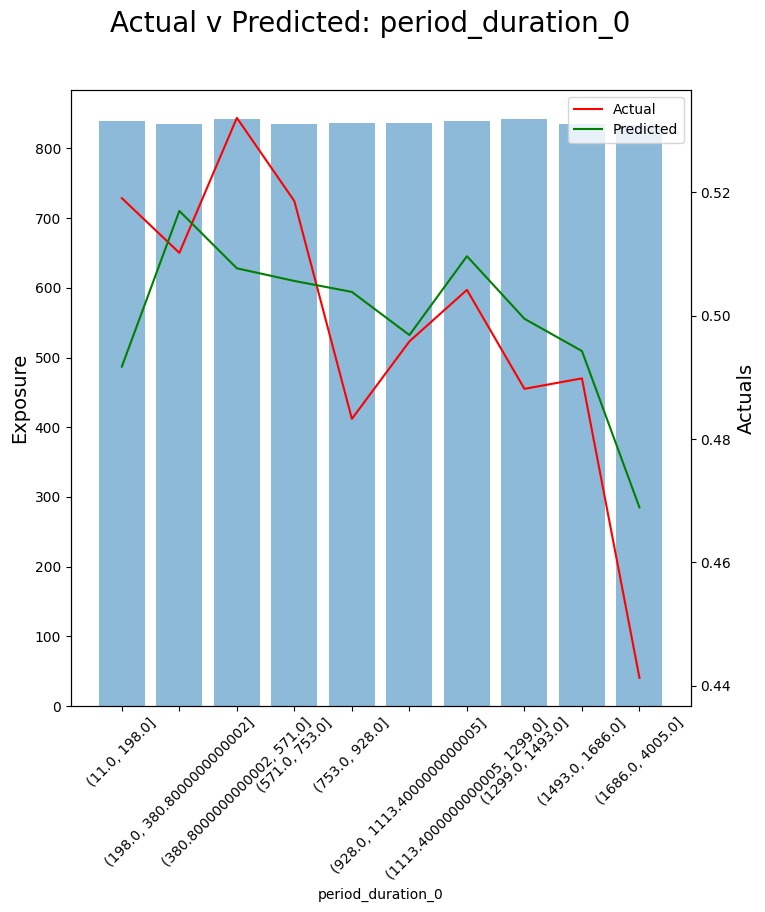

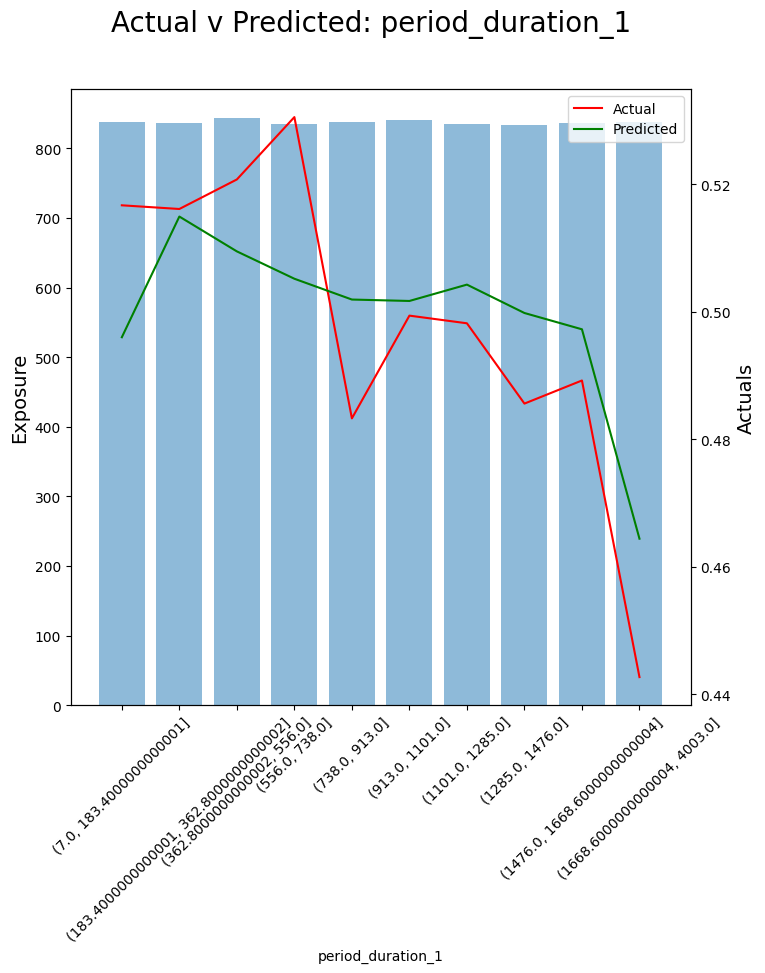

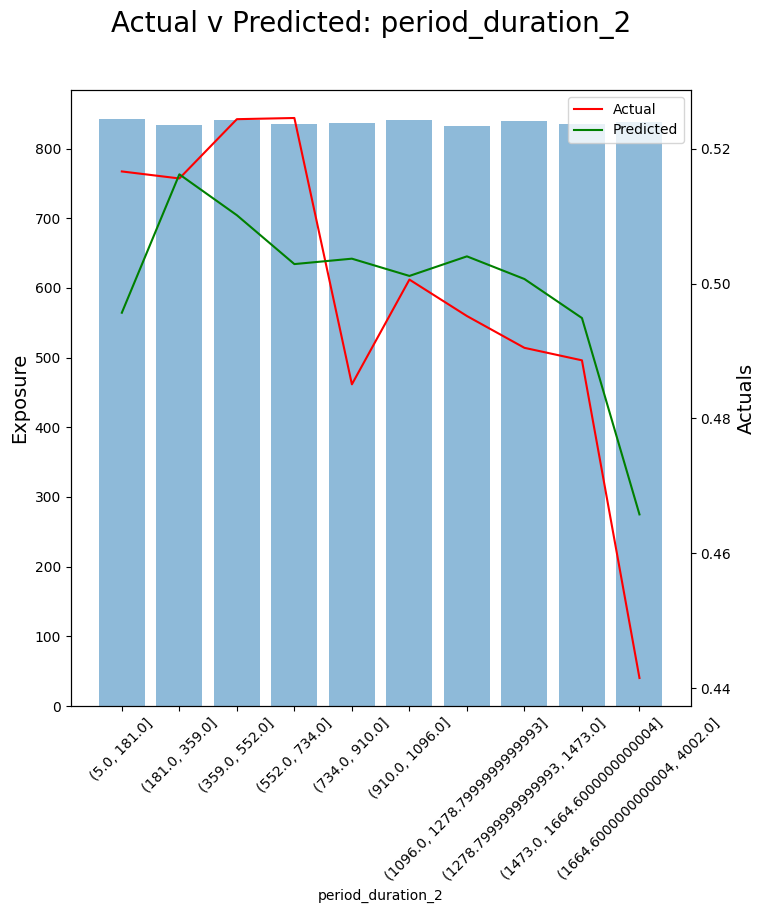

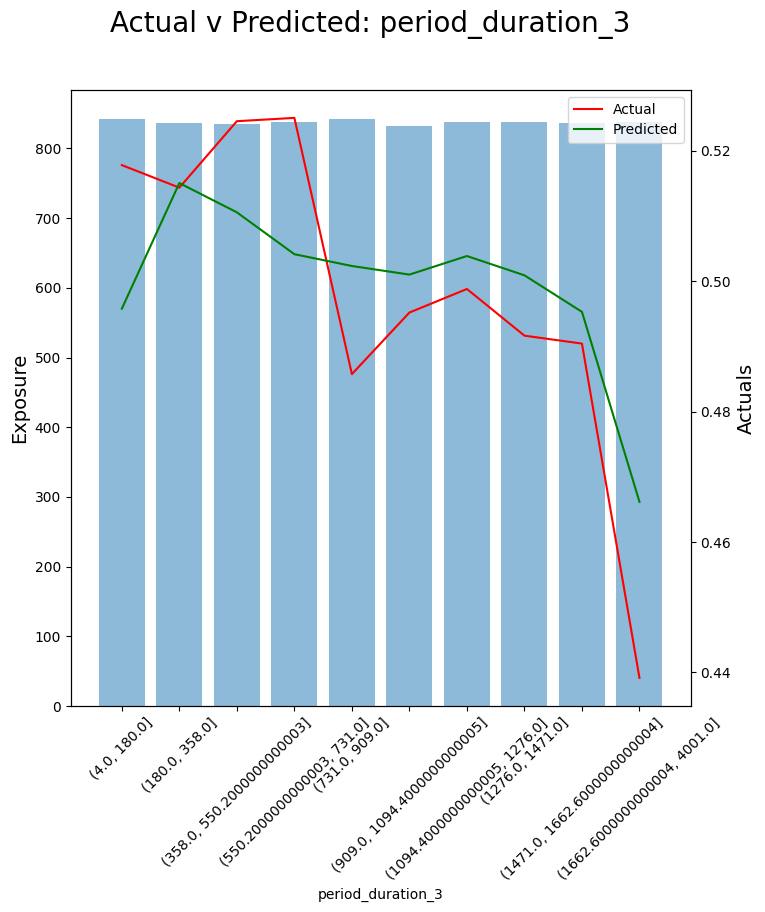

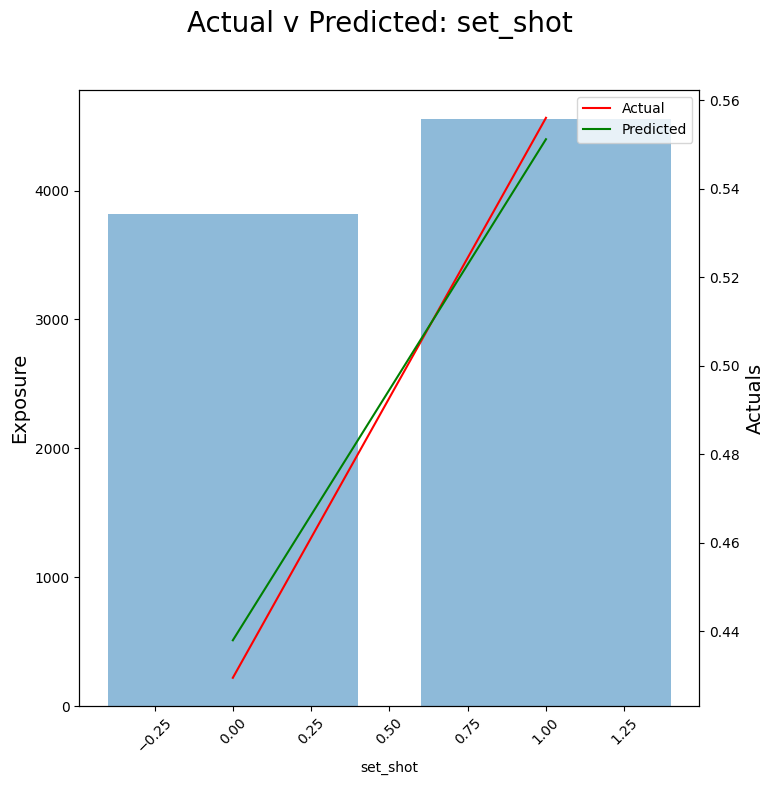

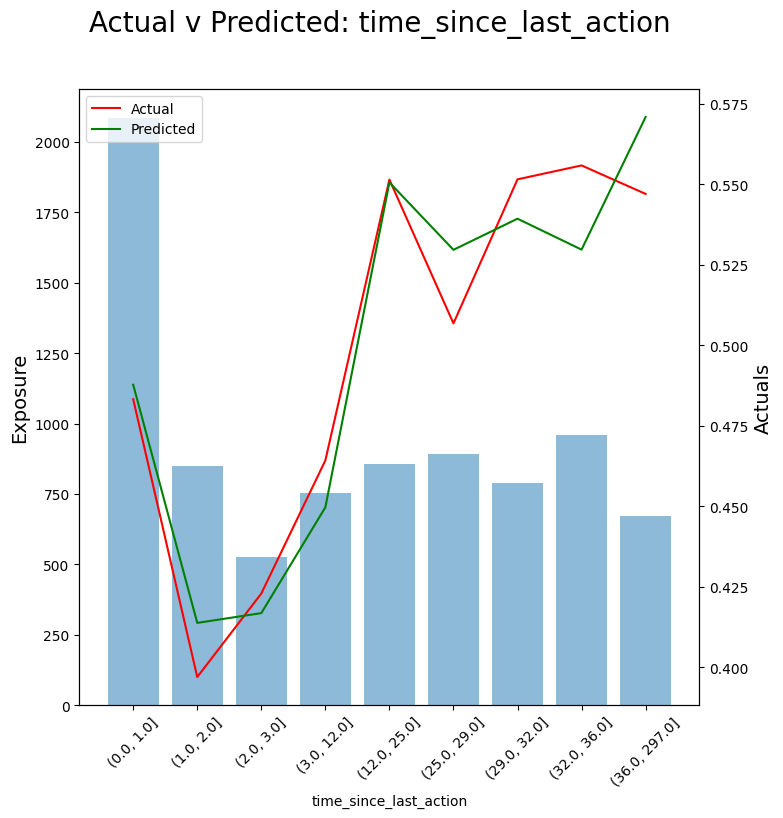

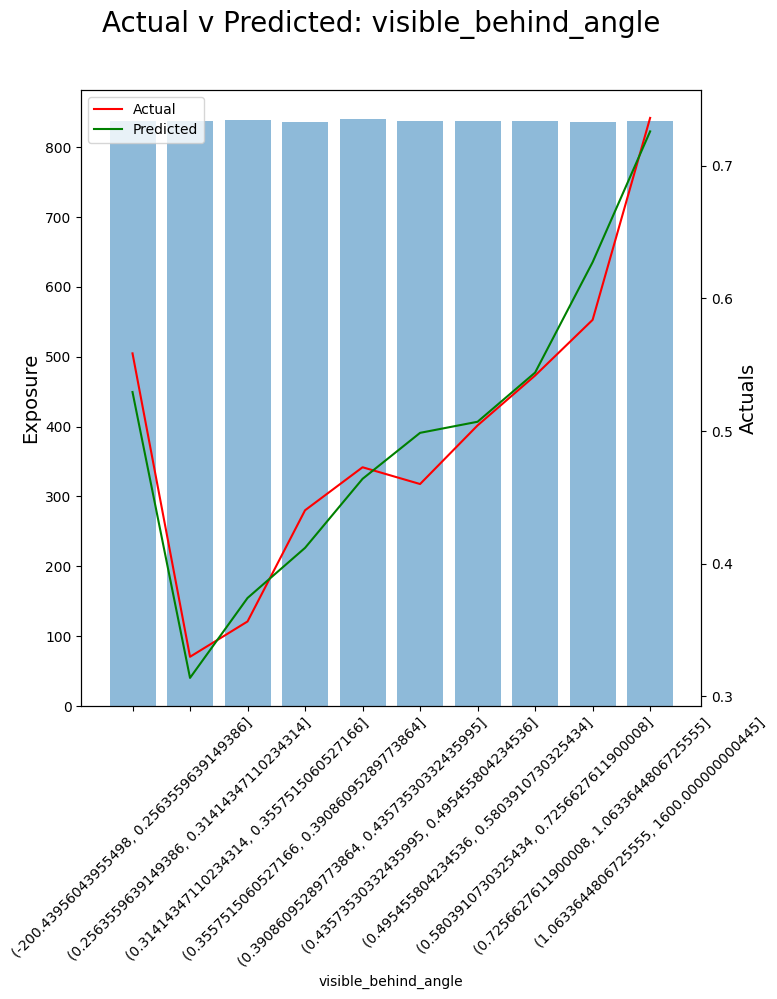

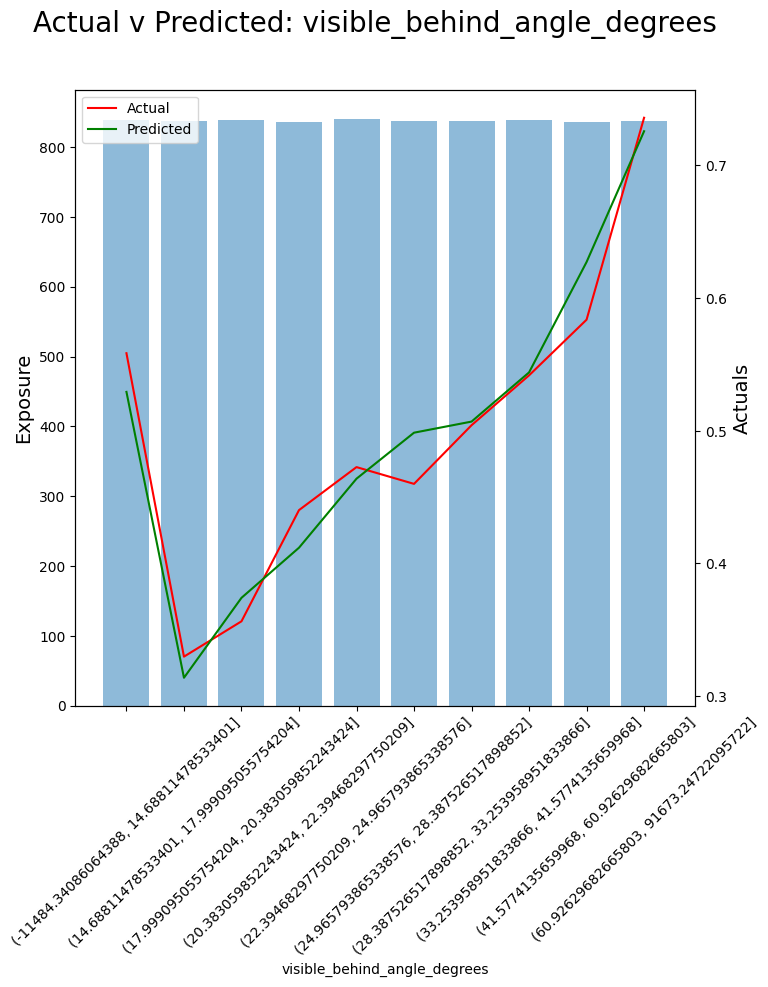

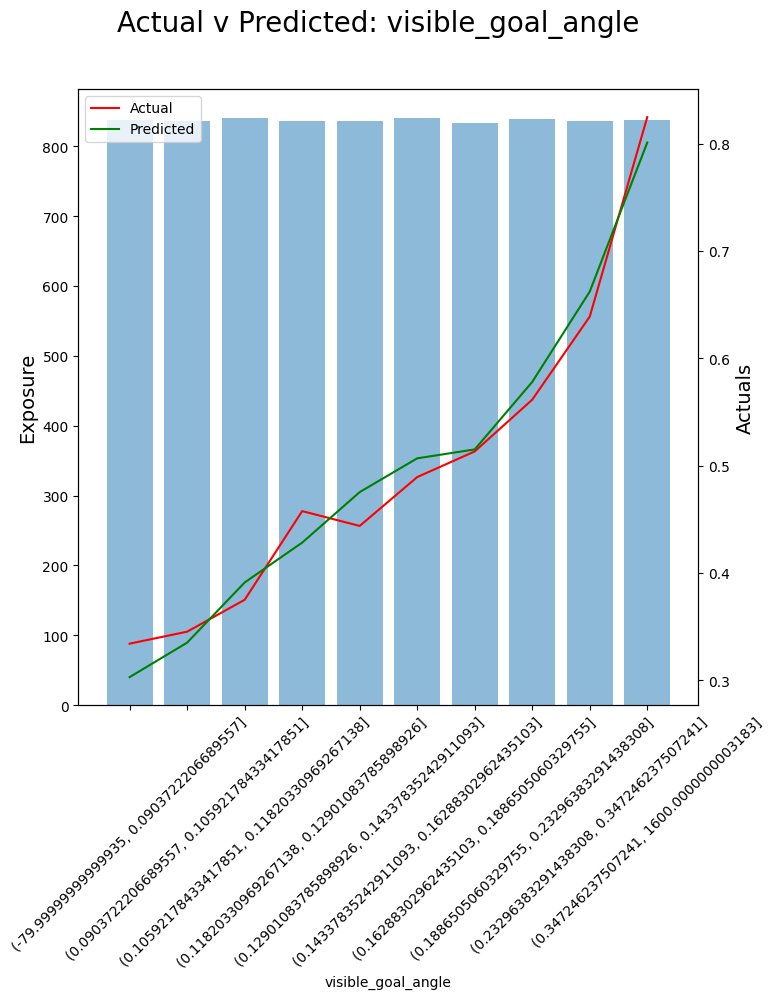

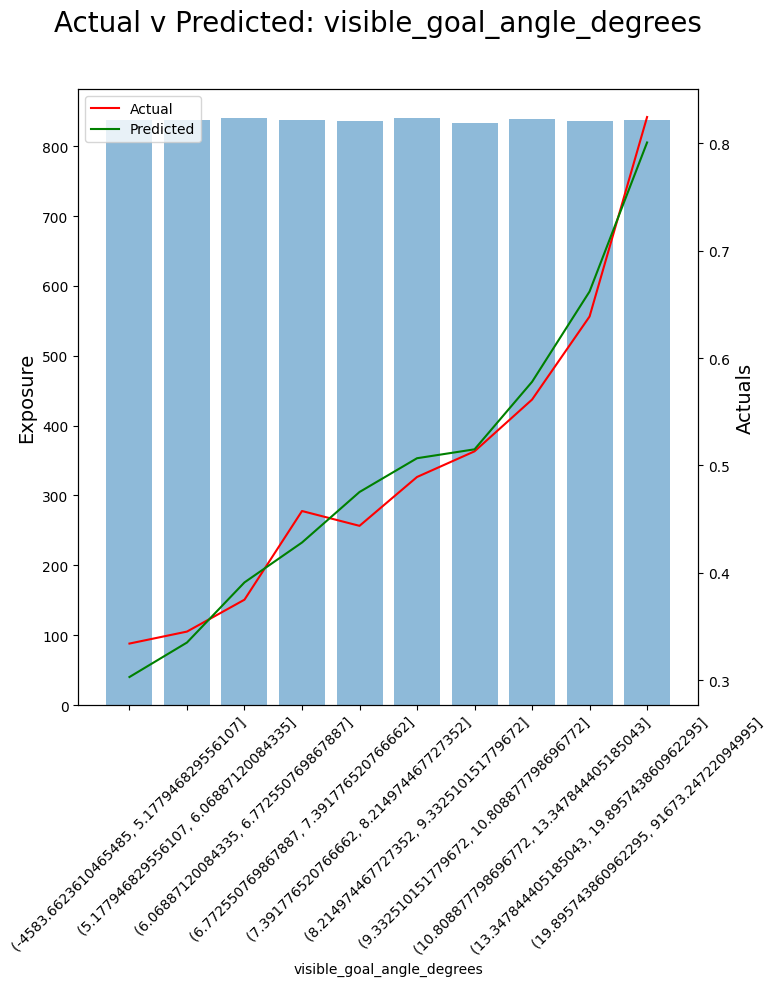

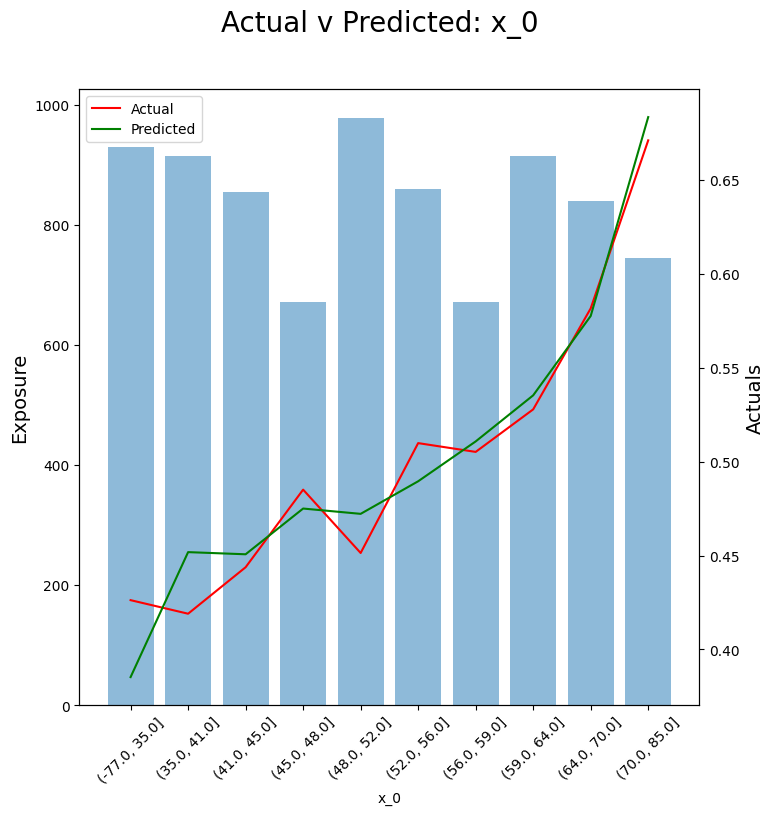

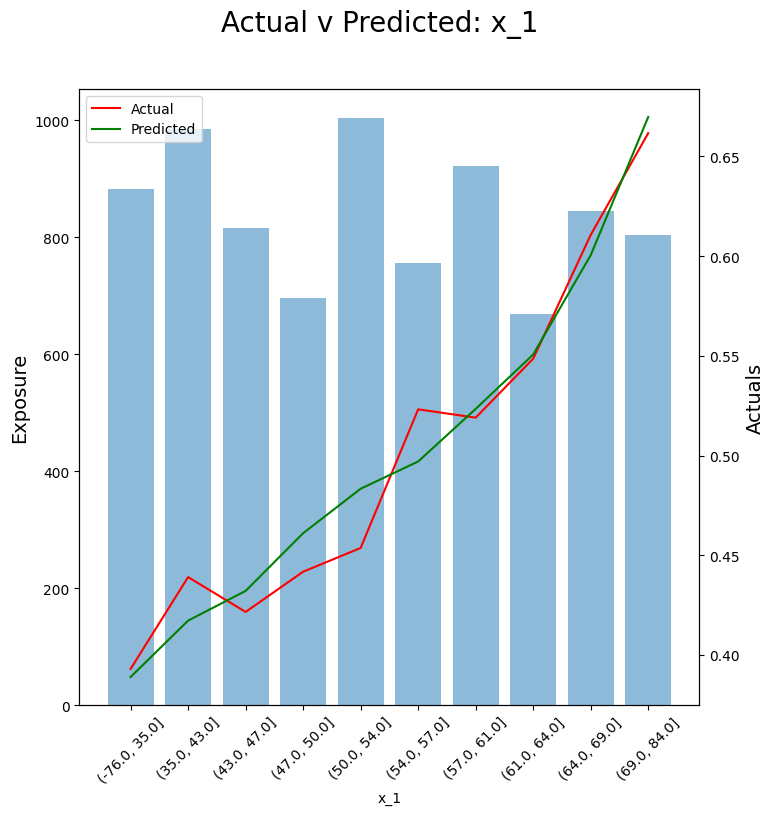

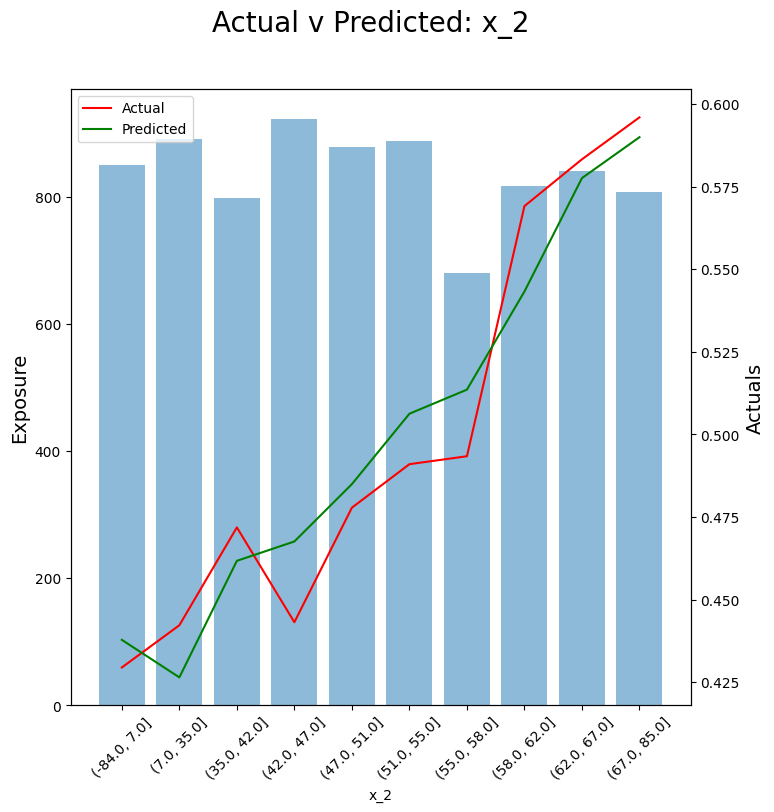

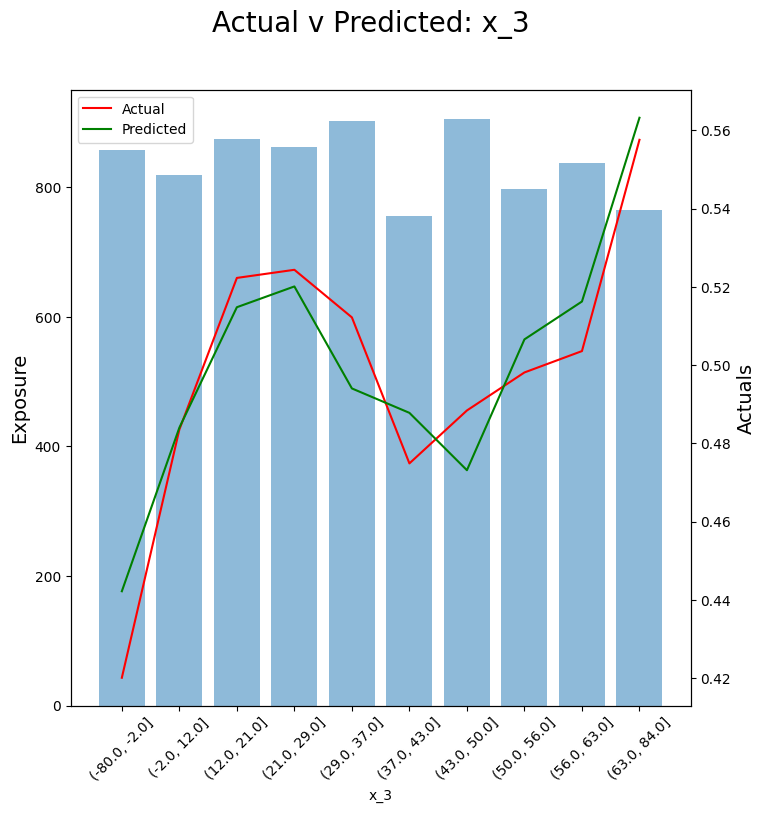

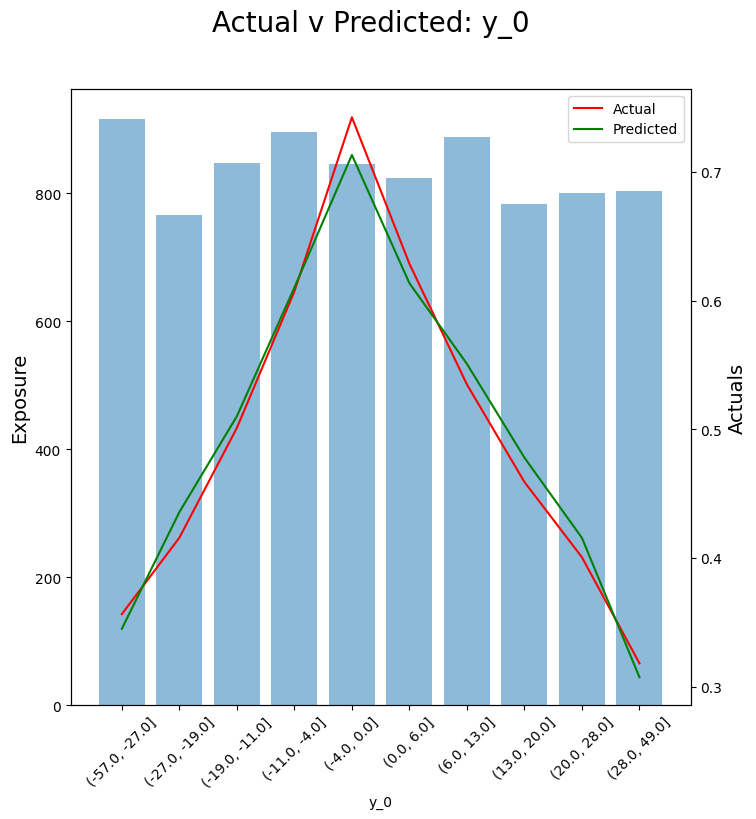

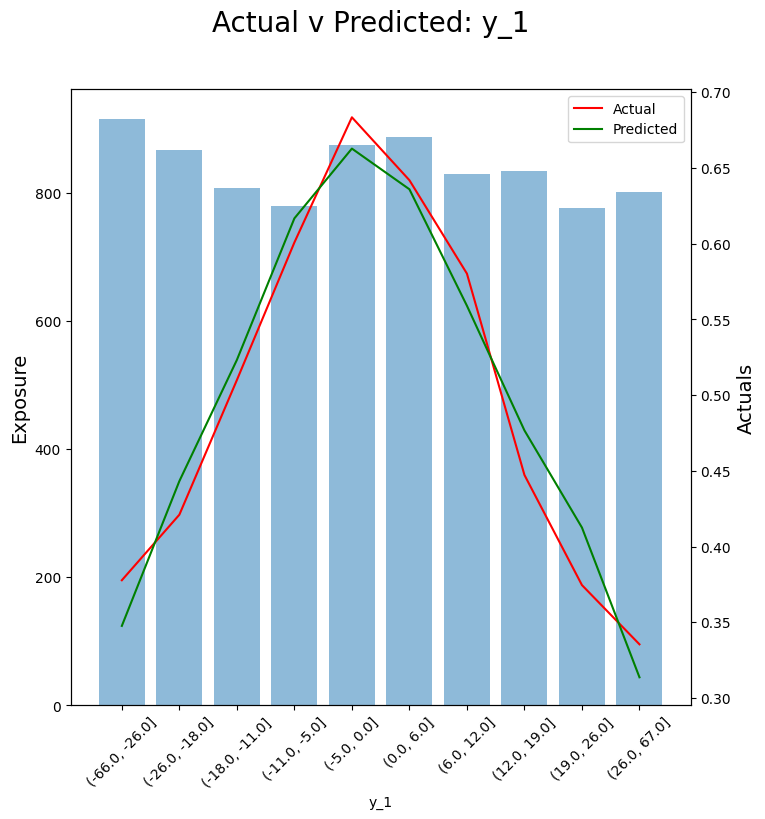

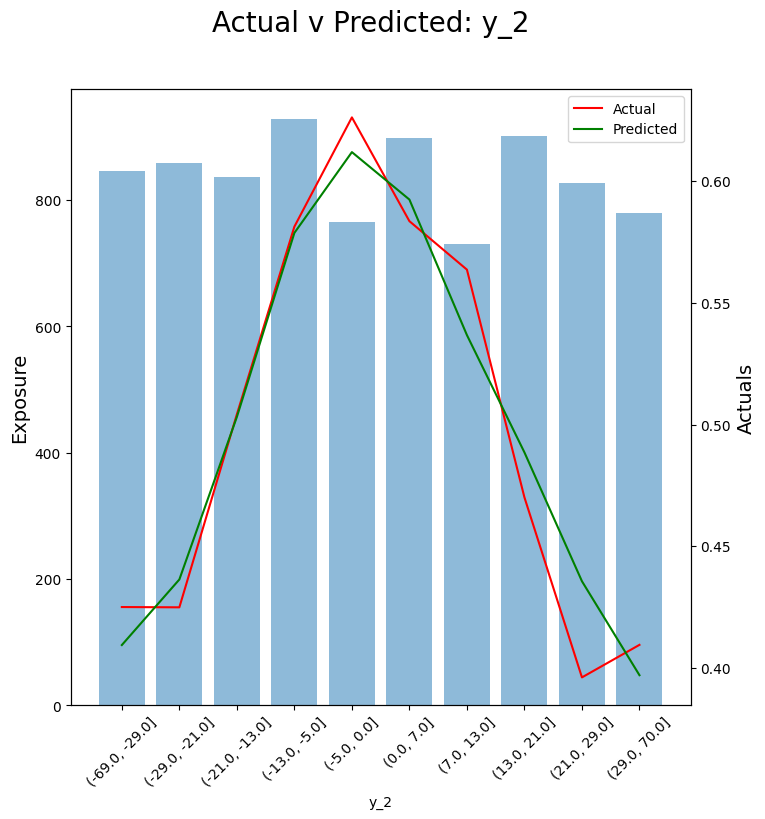

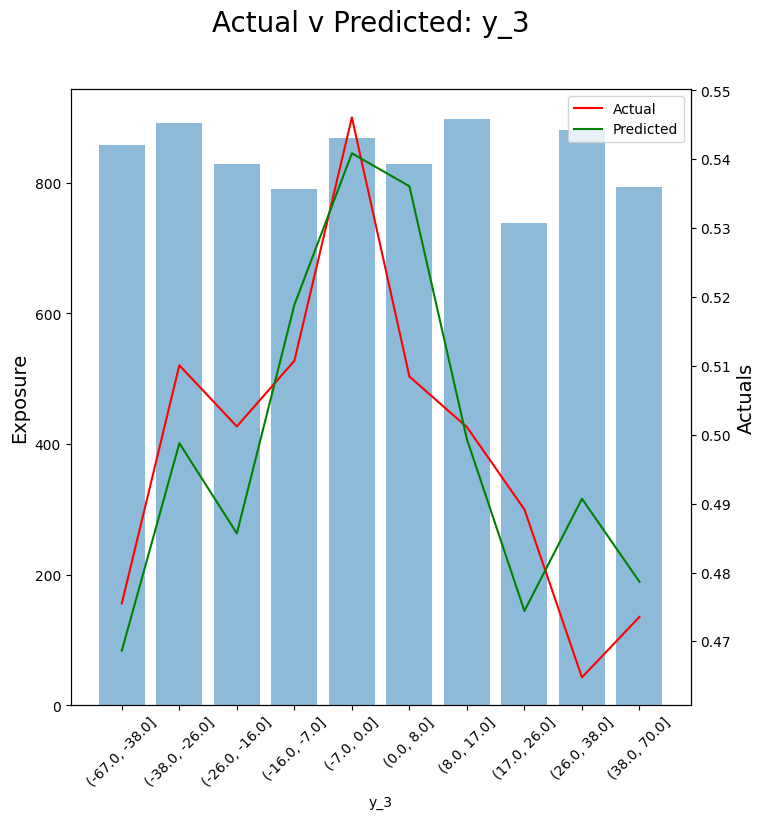

In [21]:
for feature in model.feature_names_:
    fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_test[feature], feature_name = feature)

Classification

In [22]:
multi_class_model_eval = ClassificationModelEvaluator(model = model, classification_type='multi')

In [23]:
model.classes_

array(['behind', 'goal', 'miss'], dtype=object)

In [24]:
actual_label = y_test
predicted_label = predicted_result

In [35]:
multi_class_model_eval.get_log_loss(actual = actuals_binary, predictions = predicted_probabilities)

{'class_behind': 0.6175222763904539,
 'class_goal': 0.6046900225349507,
 'class_miss': 0.38378471087153937}

In [36]:
multi_class_model_eval.get_brier_score_loss(actual = actuals_binary, predictions = predicted_probabilities)

{'class_behind': 0.21641566608763094,
 'class_goal': 0.210223469905734,
 'class_miss': 0.12105038145175366}

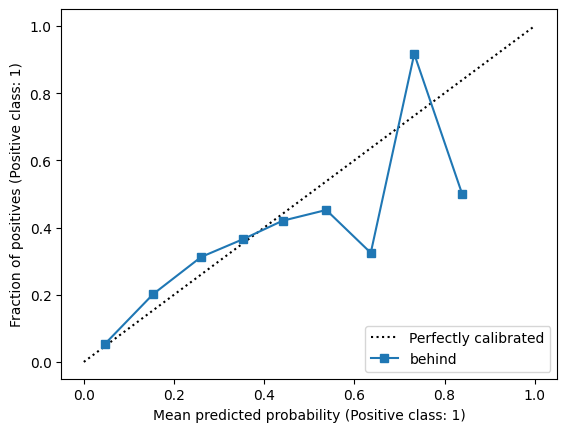

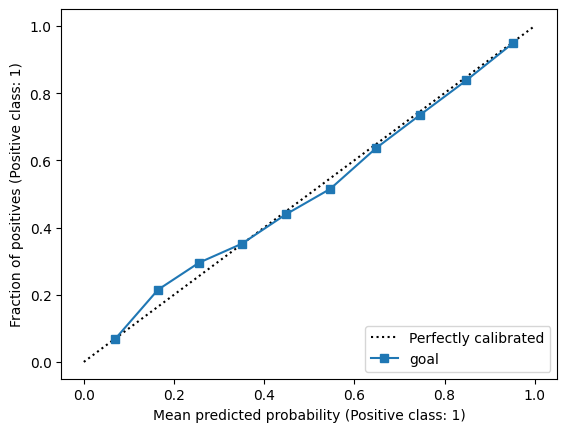

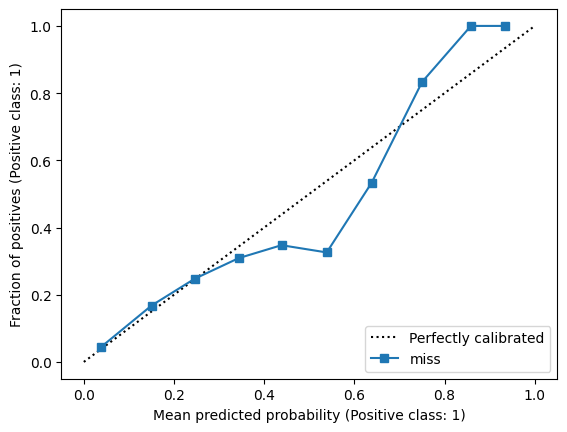

In [37]:
multi_class_model_eval.display_calibration_curve(actual = actuals_binary, predictions = predicted_probabilities, nbins=10) 

In [38]:
multi_class_model_eval.get_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

array([[1088, 1575,  216],
       [ 872, 3156,  145],
       [ 607,  499,  217]])

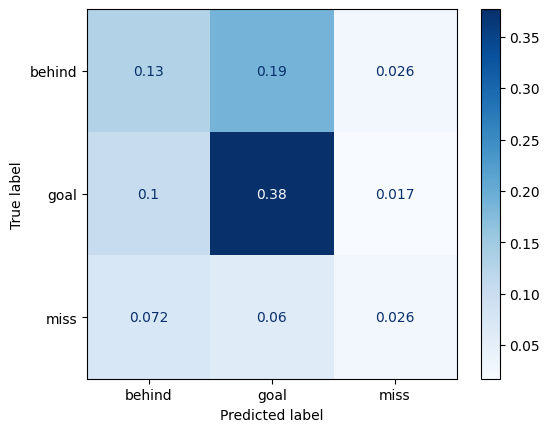

In [39]:
multi_class_model_eval.display_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

In [40]:
specified_class = 'goal'
class_label = np.where(actual_label == specified_class, 1, 0)
predicted_class_label = np.where(predicted_label == specified_class, 1, 0)

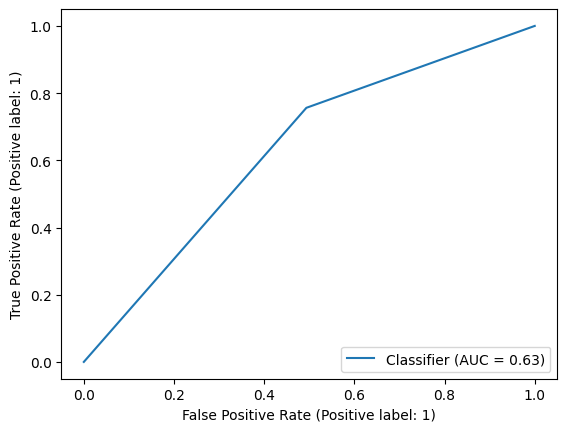

In [41]:
multi_class_model_eval.plot_roc_curve(actual_label=class_label, predicted_label=predicted_class_label)

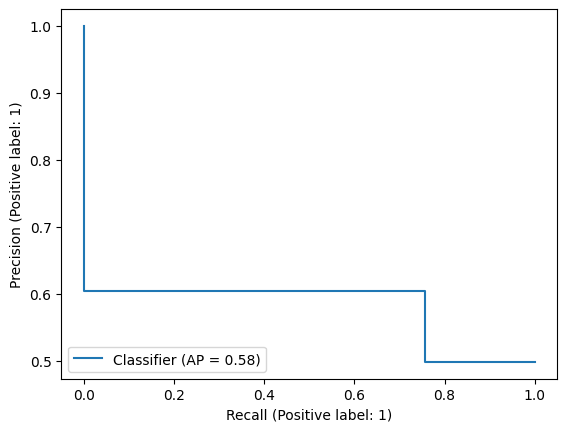

In [42]:
multi_class_model_eval.plot_prauc_curve(actual_label=class_label, predicted_label=predicted_class_label)

In [43]:
regression_model_eval = RegressionModelEvaluator(model = model)

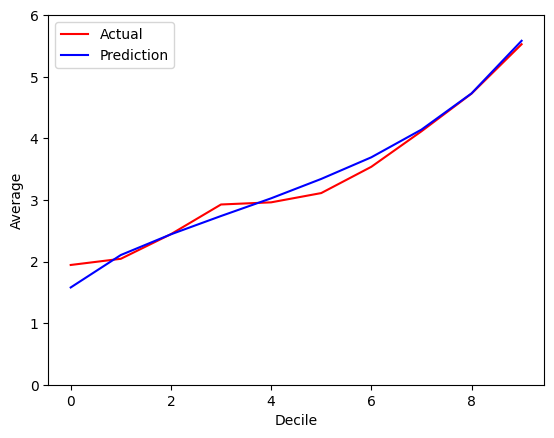

In [45]:
fig, ax = regression_model_eval.plot_decile(actual = score, predictions = predicted_score)

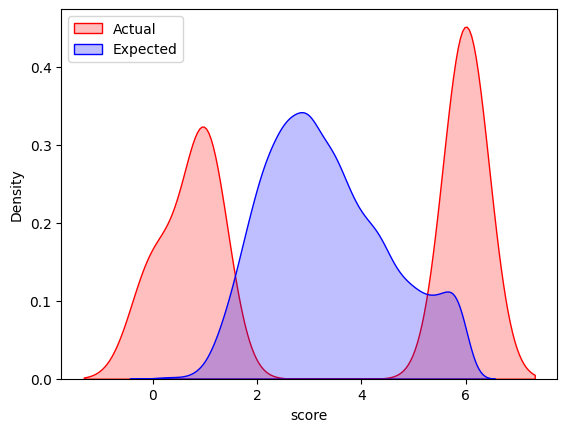

In [46]:
fig, ax = regression_model_eval.plot_distribution(actual = score, predictions = predicted_score)

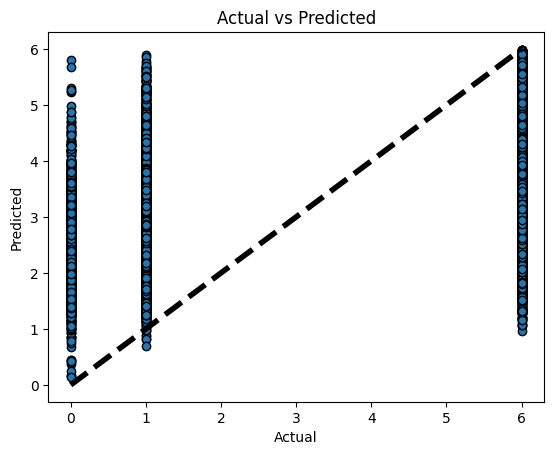

In [47]:
fig, ax = regression_model_eval.plot_ave(actual = score, predictions = predicted_score)

CatBoost Evaluation

In [48]:
cb_model_evaluator = CatBoostEvaluator(
    catboost_model = model,
    evaluator = ClassificationModelEvaluator
)   

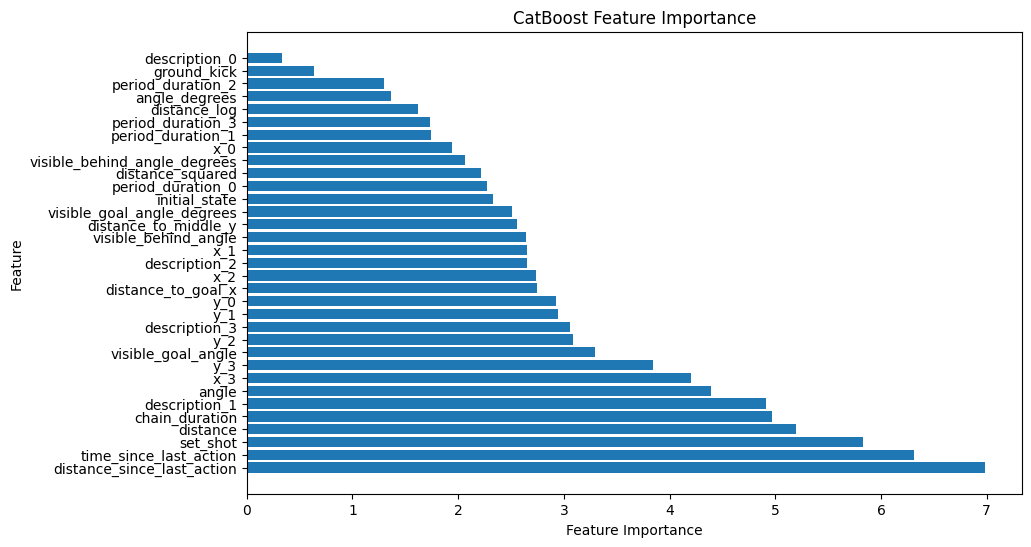

In [49]:
fig, ax = cb_model_evaluator.plot_feature_importance()

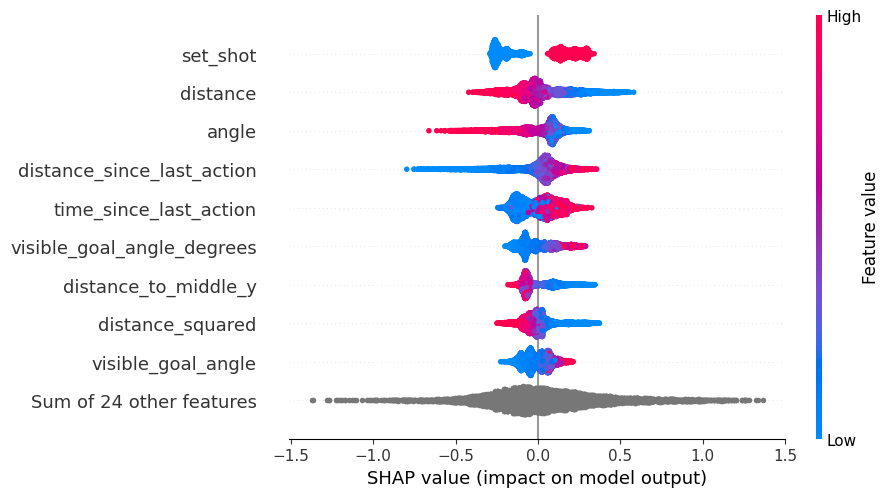

In [50]:
cb_model_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class='goal', max_display=10)

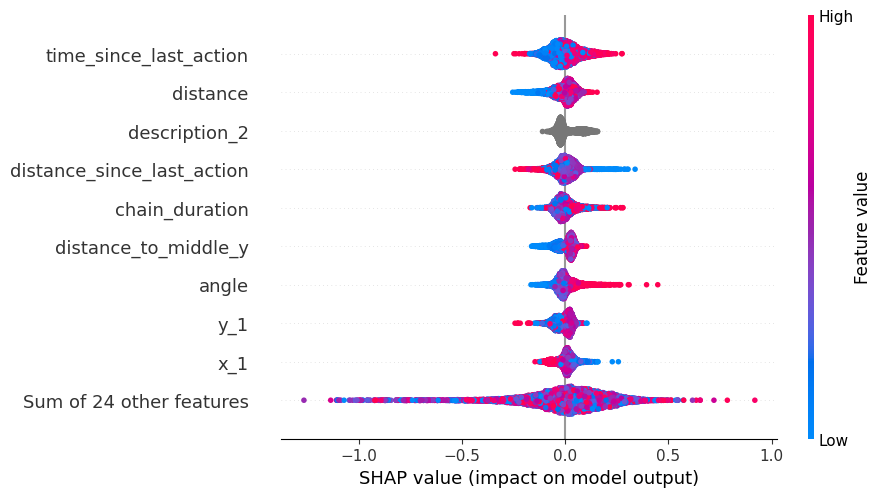

In [51]:
cb_model_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class='behind', max_display=10)

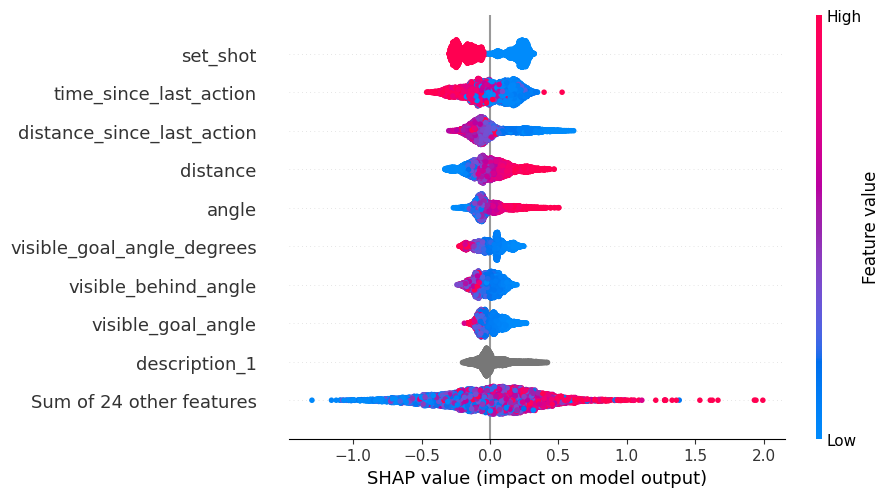

In [52]:
cb_model_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class='miss', max_display=10)